# Download data

In [1]:
# Fruits-360 dataset をダウンロードし、解凍する

!wget https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/rp73yg93n8-1.zip -nc -P ./data/
!unzip -n ./data/rp73yg93n8-1.zip -d ./data/
!unzip -n -q ./data/fruits-360_dataset.zip -d ./data/ 

--2021-02-11 04:02:25--  https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/rp73yg93n8-1.zip
Resolving md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com (md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com)... 52.218.62.16
Connecting to md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com (md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com)|52.218.62.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 418811602 (399M) [application/octet-stream]
Saving to: ‘./data/rp73yg93n8-1.zip’

rp73yg93n8-1.zip    100%[===================>] 399.41M  21.8MB/s    in 19s     

2021-02-11 04:02:45 (20.5 MB/s) - ‘./data/rp73yg93n8-1.zip’ saved [418811602/418811602]

Archive:  ./data/rp73yg93n8-1.zip
  inflating: ./data/fruits-360_dataset.zip  


# Import 

In [2]:
import os
import random
from glob import glob
from warnings import filterwarnings

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.init as init
from natsort import natsorted
from PIL import Image
from skimage import io, transform
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
from torch.utils.data import Dataset
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
from torchvision.utils import make_grid, save_image

from torchsummary import summary

filterwarnings("ignore")  # warningをオフにする

# Config

In [3]:
IMAGE_SIZE = 96  # 画像の読み込みサイズ
EMBED_SIZE = 128  # 潜在変数zの次元数
BATCH_SIZE = 16  # バッチサイズ
EPOCHS = 1000  # エポック数
LR = 0.0004  # 学習率

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"  # GPUが使えるならGPUで、そうでないならCPUで計算する
kwargs = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}  

In [5]:
COLAB_FLG = False  # COLABで実行する場合はTrue, それ以外で実行する場合はFalse

if COLAB_FLG:
    from google.colab import drive
    drive.mount('/content/gdrive') # マウント先
    ATTACH_PATH = "/content/gdrive/My Drive/PyTorch-GAN/"  # 保存先のベースディレクトリ
else:
    ATTACH_PATH = "."  # ローカルならカレントディレクトリ
    
    
SAVE_MODEL_PATH = f"{ATTACH_PATH}/results/AnoGAN/model/"  # モデルの保存先
SAVE_IMAGE_FROM_Z_PATH = f"{ATTACH_PATH}/results/AnoGAN/image/image_from_z/"  # 乱数から生成した画像の保存先

# 保存先のディレクトリを作成する
os.makedirs(SAVE_MODEL_PATH, exist_ok=True)  
os.makedirs(SAVE_IMAGE_FROM_Z_PATH, exist_ok=True)  

# Data Loader

In [6]:
train_root = './data/fruits-360/Training/Physalis/'  # train dataの保存してあるディレクトリ
val_root = './data/fruits-360/Test/Physalis/'  # val dataの保存してあるディレクトリ

In [7]:
# ディレクトリから画像を読み込んでDataLoaderに渡す用のクラス

class LoadFromFolder(Dataset):
    def __init__(self, main_dir, transform):
        self.main_dir = main_dir
        self.transform = transform
        all_imgs = natsorted(os.listdir(main_dir))
        self.all_imgs_name = natsorted(all_imgs)
        self.imgs_loc = [os.path.join(self.main_dir, i) for i in self.all_imgs_name]

    def __len__(self):
        return len(self.all_imgs_name)
    
    def load_image(self, path):
        image = Image.open(path).convert("RGB")
        tensor_image = self.transform(image)
        return tensor_image
    
    def __getitem__(self, idx):
        
        # 後ほどsliceで画像を複数枚取得したいのでsliceでも取れるようにする
        if type(idx) == slice:
            paths = self.imgs_loc[idx]
            tensor_image = [self.load_image(path) for path in paths]
            tensor_image = torch.cat(tensor_image).reshape(len(tensor_image), *tensor_image[0].shape)
        elif type(idx) == int:
            path = self.imgs_loc[idx]
            tensor_image = self.load_image(path)
        return tensor_image

In [8]:
# 画像を読み込む際の前処理

transform_dict = {
    "train": transforms.Compose(
        [
            transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),  # IMAGE_SIZEにreshape
            transforms.RandomHorizontalFlip(), # ランダムに左右反転を行う
            transforms.ToTensor(),
        ]
    ),
    "test": transforms.Compose(
        [
            transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),  # IMAGE_SIZEにreshape
            transforms.ToTensor(),
        ]
    ),
}

In [9]:
# 読み込む
train_dataset = LoadFromFolder(train_root, transform=transform_dict["train"])

test_dataset = LoadFromFolder(val_root, transform=transform_dict["test"])

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size = BATCH_SIZE, shuffle=True, **kwargs)

val_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size = BATCH_SIZE, shuffle=True, **kwargs)

# Model

In [10]:
class Generator(nn.Module):
    def __init__(self, EMBED_SIZE=EMBED_SIZE):
        super().__init__()
        
        self.main = nn.Sequential(
            nn.ConvTranspose2d(EMBED_SIZE, 256, kernel_size=6, stride=1, padding=0, bias=False), # 6x6
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False), # 12x12
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False), # 24x24
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, bias=False), # 48x48
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1, bias=False), #96x96
            nn.Tanh()
        )

    def forward(self, z):
        out = self.main(z)
        return out

In [11]:
# ネットワークを可視化する

summary(Generator().to(device), tuple([EMBED_SIZE, 1, 1]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 6, 6]       1,179,648
       BatchNorm2d-2            [-1, 256, 6, 6]             512
              ReLU-3            [-1, 256, 6, 6]               0
   ConvTranspose2d-4          [-1, 128, 12, 12]         524,288
       BatchNorm2d-5          [-1, 128, 12, 12]             256
              ReLU-6          [-1, 128, 12, 12]               0
   ConvTranspose2d-7           [-1, 64, 24, 24]         131,072
       BatchNorm2d-8           [-1, 64, 24, 24]             128
              ReLU-9           [-1, 64, 24, 24]               0
  ConvTranspose2d-10           [-1, 32, 48, 48]          32,768
      BatchNorm2d-11           [-1, 32, 48, 48]              64
             ReLU-12           [-1, 32, 48, 48]               0
  ConvTranspose2d-13            [-1, 3, 96, 96]           1,536
             Tanh-14            [-1, 3,

In [12]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.1, inplace=True), #48x48
            nn.Dropout2d(p=0.3),
            
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1, inplace=True), #24x24
            nn.Dropout2d(p=0.3),
            

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1, inplace=True), #12x12
            nn.Dropout2d(p=0.3),
            
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1, inplace=True), #6x6
            nn.Dropout2d(p=0.3),

        )
        self.last = nn.Sequential(
            nn.Conv2d(256, 1, kernel_size=6, stride=1, padding=0, bias=False) # 1x1
        )

    def forward(self, x):
        feature = self.main(x)
        out = self.last(feature)
        out = F.sigmoid(out)
        feature = feature.view(feature.size()[0], -1)
        out = out.squeeze()
        return out, feature
    

In [13]:
# ネットワークを可視化する

summary(Discriminator().to(device), (3, IMAGE_SIZE, IMAGE_SIZE))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 48, 48]           1,536
         LeakyReLU-2           [-1, 32, 48, 48]               0
         Dropout2d-3           [-1, 32, 48, 48]               0
            Conv2d-4           [-1, 64, 24, 24]          32,768
       BatchNorm2d-5           [-1, 64, 24, 24]             128
         LeakyReLU-6           [-1, 64, 24, 24]               0
         Dropout2d-7           [-1, 64, 24, 24]               0
            Conv2d-8          [-1, 128, 12, 12]         131,072
       BatchNorm2d-9          [-1, 128, 12, 12]             256
        LeakyReLU-10          [-1, 128, 12, 12]               0
        Dropout2d-11          [-1, 128, 12, 12]               0
           Conv2d-12            [-1, 256, 6, 6]         524,288
      BatchNorm2d-13            [-1, 256, 6, 6]             512
        LeakyReLU-14            [-1, 25

In [14]:
# 重みの初期化を行う関数

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [15]:
model_G = Generator().to(device)
model_G.apply(weights_init)

model_D = Discriminator().to(device)
model_D.apply(weights_init)

criterion = nn.BCELoss()  # 評価関数
optimizer_g = torch.optim.Adam(model_G.parameters(), lr= LR,betas=(0.5,0.999))  # Generatorのoptimizer
optimizer_d = torch.optim.Adam(model_D.parameters(), lr= LR,betas=(0.5,0.999))  # Discriminatorのoptimizer

# train

In [17]:
loss_d_list, loss_g_list = [], []


for epoch in range(EPOCHS + 1):
    loss_d_sum = 0
    loss_g_sum = 0
    
    for i,(x, x_val) in enumerate(zip(train_loader, val_loader)):
        
        model_G.train()
        model_D.train()
        
        # set values
        y_true = Variable(torch.ones(x.size()[0])).to(device)
        y_fake = Variable(torch.zeros(x.size()[0])).to(device)
        
        x = Variable(x).to(device)
        z = Variable(init.normal(torch.Tensor(x.size()[0],EMBED_SIZE, 1, 1),mean=0,std=0.1)).to(device)
        

        # discriminator
        optimizer_d.zero_grad()
        
        G_z = model_G(z)
        p_true, _ = model_D(x)
        p_fake, _ = model_D(G_z)
        
        loss_d = criterion(p_true, y_true) + criterion(p_fake, y_fake)
        loss_d.backward(retain_graph=True)
        optimizer_d.step()
        
        # generator and encoder
        optimizer_g.zero_grad()
        
        p_true, _ = model_D(x)
        p_fake, _ = model_D(G_z)        
        
        loss_g = criterion(p_fake, y_true) + criterion(p_true, y_fake)
        loss_g.backward(retain_graph=True)
        optimizer_g.step()
        
        
        loss_d_sum += loss_d.item()
        loss_g_sum += loss_g.item()
        
            
        # save images
        if i == 0:
            
            model_G.eval()
            model_D.eval()
        
            save_image_size_for_z = min(BATCH_SIZE, 8)
            save_images = model_G(z)
            save_image(save_images[:save_image_size_for_z], f"{SAVE_IMAGE_FROM_Z_PATH}/epoch_{epoch}.png", nrow=4)

        
        
    # record loss
    loss_d_mean = loss_d_sum / len(train_loader)
    loss_g_mean = loss_g_sum / len(train_loader)
    
    print(f"{epoch}/{EPOCHS} epoch g_loss: {loss_g_mean:.3f} d_loss: {loss_d_mean:.3f}")
    
    loss_d_list.append(loss_d_mean)
    loss_g_list.append(loss_g_mean)
    
    # save model
    if (epoch) % 10 == 0:
        torch.save(model_G.state_dict(),f'{SAVE_MODEL_PATH}/Generator_{epoch}.pkl')
        torch.save(model_D.state_dict(),f'{SAVE_MODEL_PATH}/Discriminator_{epoch}.pkl')


0/1000 epoch g_loss: 2.513 d_loss: 0.185
1/1000 epoch g_loss: 2.427 d_loss: 0.194
2/1000 epoch g_loss: 2.324 d_loss: 0.210
3/1000 epoch g_loss: 2.213 d_loss: 0.214
4/1000 epoch g_loss: 2.240 d_loss: 0.172
5/1000 epoch g_loss: 2.221 d_loss: 0.153
6/1000 epoch g_loss: 2.307 d_loss: 0.217
7/1000 epoch g_loss: 2.352 d_loss: 0.167
8/1000 epoch g_loss: 2.233 d_loss: 0.182
9/1000 epoch g_loss: 2.351 d_loss: 0.196
10/1000 epoch g_loss: 2.249 d_loss: 0.156
11/1000 epoch g_loss: 2.336 d_loss: 0.165
12/1000 epoch g_loss: 2.406 d_loss: 0.187
13/1000 epoch g_loss: 2.236 d_loss: 0.160
14/1000 epoch g_loss: 2.512 d_loss: 0.184
15/1000 epoch g_loss: 2.506 d_loss: 0.191
16/1000 epoch g_loss: 2.282 d_loss: 0.194
17/1000 epoch g_loss: 2.522 d_loss: 0.176
18/1000 epoch g_loss: 2.407 d_loss: 0.179
19/1000 epoch g_loss: 2.564 d_loss: 0.150
20/1000 epoch g_loss: 2.359 d_loss: 0.178
21/1000 epoch g_loss: 2.375 d_loss: 0.177
22/1000 epoch g_loss: 2.326 d_loss: 0.287
23/1000 epoch g_loss: 2.334 d_loss: 0.255
24

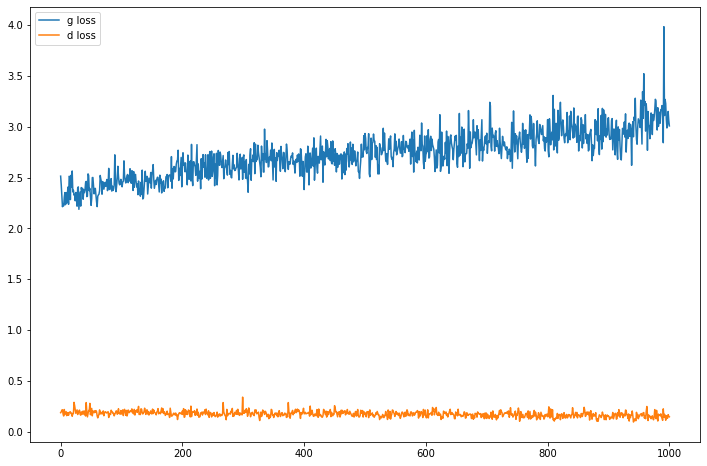

In [18]:
# GeneratorとDiscriminatorのLossの推移
plt.figure(figsize=(12, 8))

plt.plot(range(len(loss_g_list)), loss_g_list, label="g loss")
plt.plot(range(len(loss_d_list)), loss_d_list, label="d loss")
plt.legend()
plt.show()

# Latent Z optimization and Test anomaly detection

In [31]:
# 異常度を測定する関数

criterion_L1 = nn.L1Loss(reduction="sum")

def Anomaly_score(x,G_z,Lambda=0.1):
    _,x_feature = model_D(x)
    _,G_z_feature = model_D(G_z)
    
    residual_loss = criterion_L1(x, G_z)
    discrimination_loss = criterion_L1(x_feature, G_z_feature)
    total_loss = (1-Lambda)*residual_loss + Lambda*discrimination_loss
    
    return total_loss


In [32]:
# 学習したモデルの読み込み

LOAD_EPOCH = 1000

model_G = Generator().to(device)
model_G.load_state_dict(torch.load(f"{SAVE_MODEL_PATH}/Generator_{LOAD_EPOCH}.pkl"))
model_G.eval()


model_D = Discriminator().to(device)
model_D.load_state_dict(torch.load(f"{SAVE_MODEL_PATH}/Discriminator_{LOAD_EPOCH}.pkl"))
model_D.eval()

print("load model")

load model


In [33]:
# 最適なzを探索する関数
def optimize_z(x):
    x = Variable(x).to(device)
    z = Variable(init.normal(torch.zeros(1,EMBED_SIZE, 1, 1),mean=0,std=0.1).to(device),requires_grad=True)
    z_optimizer = torch.optim.Adam([z],lr=1e-4)
    
    for i in range(1000):
        G_z = model_G(z)

        loss = Anomaly_score(x, G_z)
        loss.backward()
        z_optimizer.step()
            
    return z



Anomary_score = 1221.356


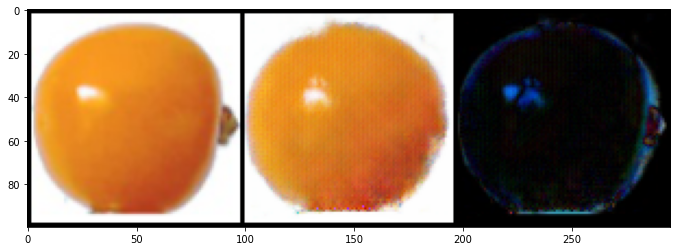

Anomary_score = 1508.942


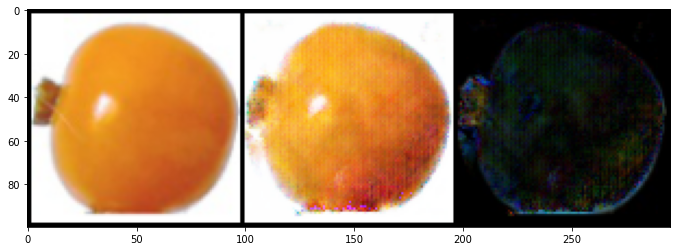

Anomary_score = 1360.056


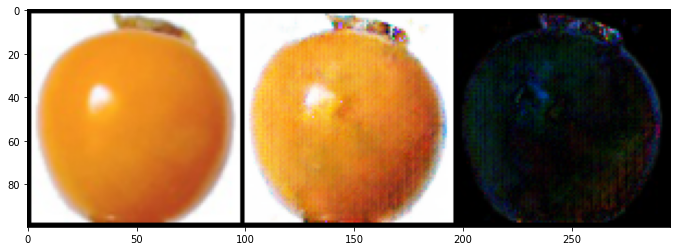

Anomary_score = 1577.122


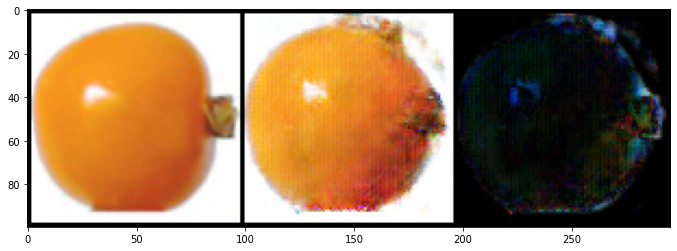

Anomary_score = 1148.326


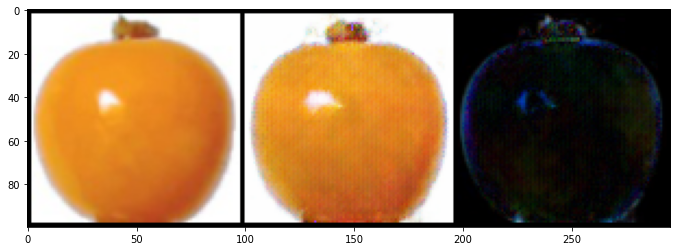

Anomary_score = 1139.624


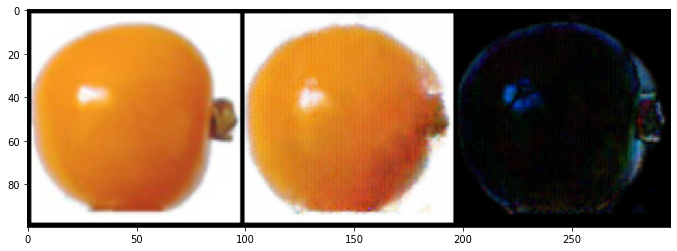

Anomary_score = 821.112


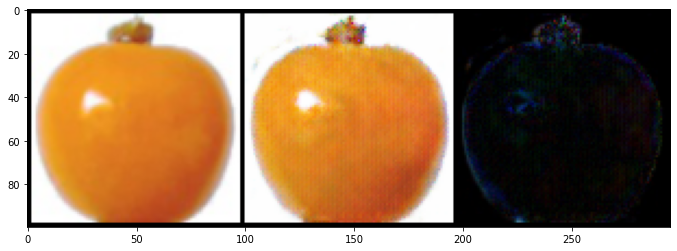

Anomary_score = 1436.511


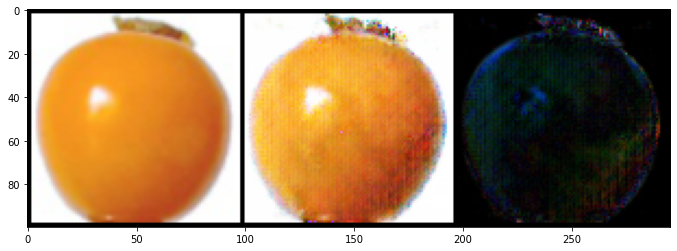

Anomary_score = 1231.208


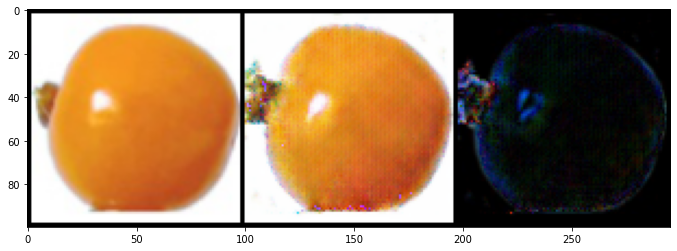

Anomary_score = 886.668


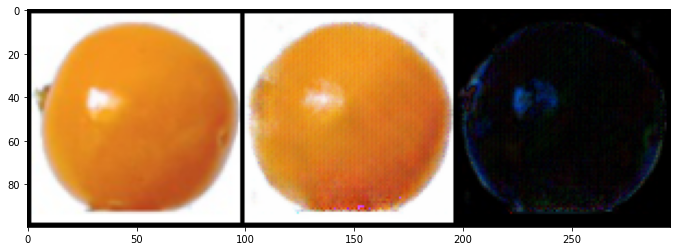

In [34]:
# 正常な画像で実行

random_image_size = 10

test_root_normal = './data/fruits-360/Test/Physalis/'
test_dataset_normal = LoadFromFolder(test_root_normal, transform=transform_dict["test"])

test_images_normal = random.sample(list(test_dataset_normal), random_image_size)

# うまく再現され、異常スコアが低くなっていれば成功
for idx in range(len(test_images_normal)):

    x = test_images_normal[idx].view(1, 3, IMAGE_SIZE, IMAGE_SIZE)
    x = Variable(x).to(device)
    
    z_o = optimize_z(x)
    G_z_o = model_G(z_o)
    loss = Anomaly_score(x, G_z_o)
    diff_img = torch.abs(x - G_z_o)

    print(f"Anomary_score = {loss.cpu().data:.3f}")
    comparison = torch.cat([x.to("cpu"), G_z_o.to("cpu"), diff_img.to("cpu")])
    joined_image = make_grid(comparison, nrow=3).detach().numpy()
    joined_image = np.transpose(joined_image, [1, 2, 0])
    
    plt.figure(figsize=(12, 4))
    plt.imshow((joined_image * 255).astype(np.uint8))
    plt.show()


Anomary_score = 4296.028


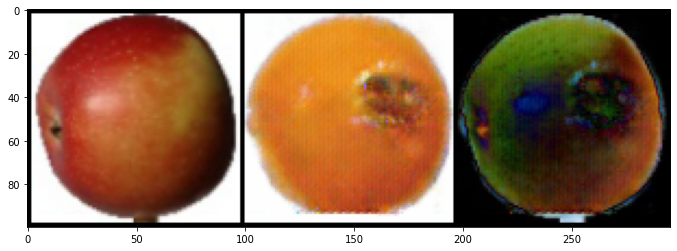

Anomary_score = 6570.538


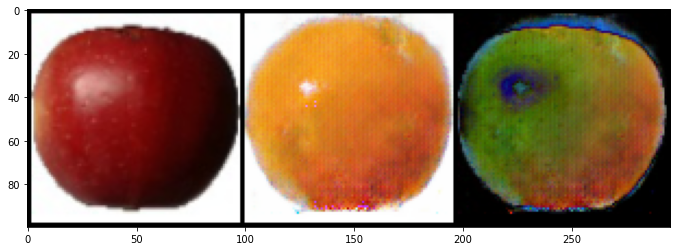

Anomary_score = 6880.080


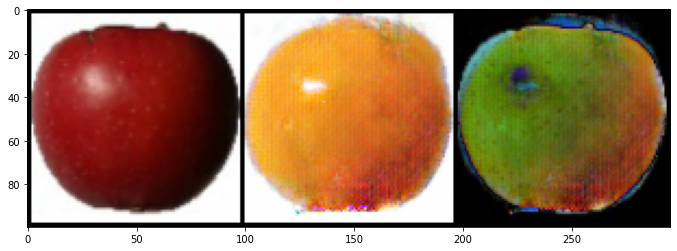

Anomary_score = 6212.836


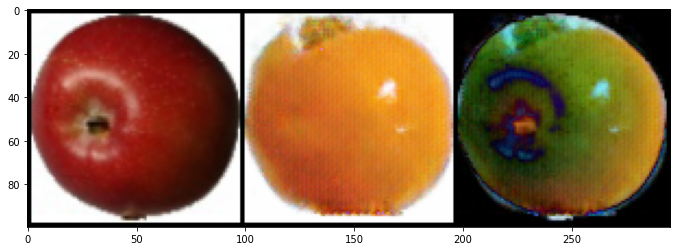

Anomary_score = 4923.243


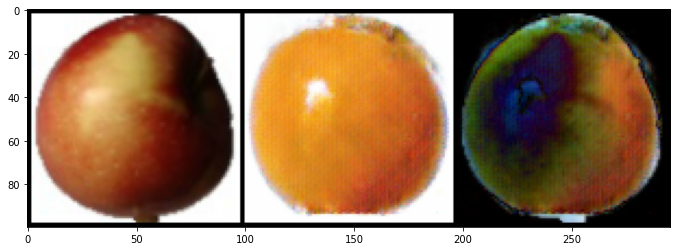

Anomary_score = 4070.446


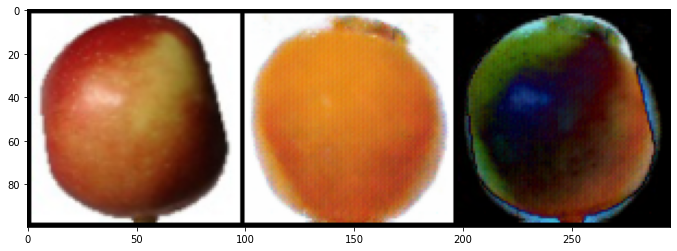

Anomary_score = 5357.958


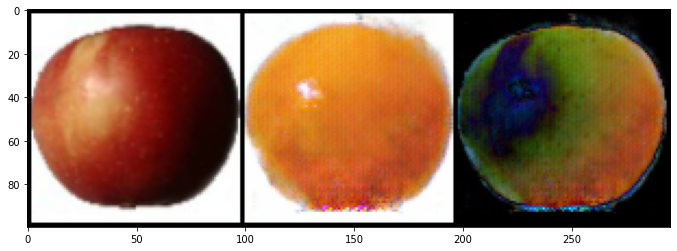

Anomary_score = 6215.108


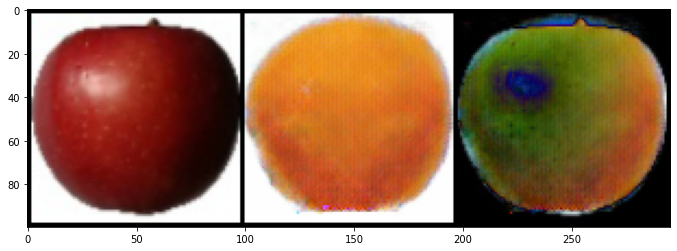

Anomary_score = 6394.175


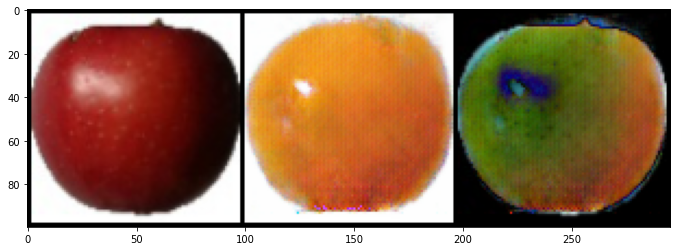

Anomary_score = 5974.246


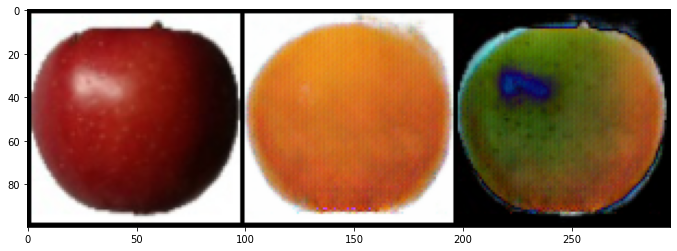

In [35]:
# 異常な画像で実行

random_image_size = 10

test_root_anomaly = './data/fruits-360/Test/Apple Braeburn/'
test_dataset_anomaly = LoadFromFolder(test_root_anomaly, transform=transform_dict["test"])

test_images_anomaly = random.sample(list(test_dataset_anomaly), random_image_size)


# うまく再現されず、異常スコアが高くなっていれば成功
for idx in range(len(test_images_anomaly)):

    x = test_images_anomaly[idx].view(1, 3, IMAGE_SIZE, IMAGE_SIZE)
    x = Variable(x).to(device)
    
    z_o = optimize_z(x)
    G_z_o = model_G(z_o)
    loss = Anomaly_score(x, G_z_o)
    diff_img = torch.abs(x - G_z_o)

    print(f"Anomary_score = {loss.cpu().data:.3f}")
    comparison = torch.cat([x.to("cpu"), G_z_o.to("cpu"), diff_img.to("cpu")])
    joined_image = make_grid(comparison, nrow=3).detach().numpy()
    joined_image = np.transpose(joined_image, [1, 2, 0])
    
    plt.figure(figsize=(12, 4))
    plt.imshow((joined_image * 255).astype(np.uint8))
    plt.show()


In [36]:
# 画像に傷を模した記号を付与する関数

def add_damage(image_path):
    
    folder = os.path.dirname(image_path)
    save_folder = folder + "_damaged"
    save_base_path = os.path.basename(image_path).replace(".jpg", "_damaged.jpg")
    save_path = os.path.join(save_folder, save_base_path)
    
    os.makedirs(save_folder, exist_ok=True)
    
    image = cv2.imread(image_path)
    center_x = random.randint(20, 76)
    center_y = random.randint(20, 76)
    color_r = random.randint(0, 255)
    color_g = random.randint(0, 255)
    color_b = random.randint(0, 255)
    
    center = (center_x, center_y)
    color = (color_r, color_g, color_b)
    
    cv2.circle(image, center = center, radius = 10, color = color,thickness=-1)
    cv2.imwrite(save_path, image)
    
images_path = glob('./data/fruits-360/Test/Physalis/*.jpg')
[add_damage(image_path) for image_path in images_path]
print("add damage")

add damage


Anomary_score = 1550.242


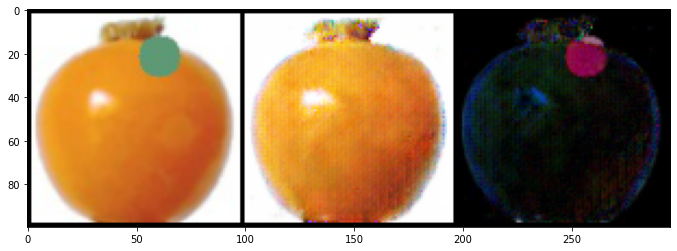

Anomary_score = 1570.530


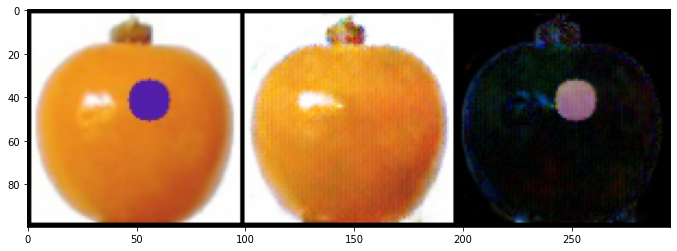

Anomary_score = 1680.837


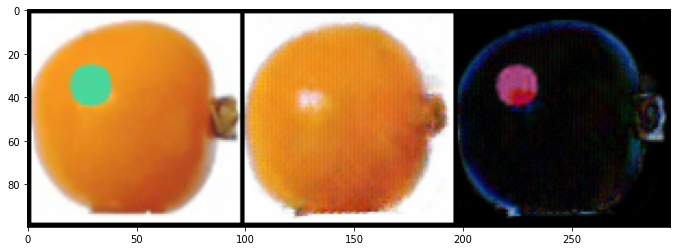

Anomary_score = 1718.049


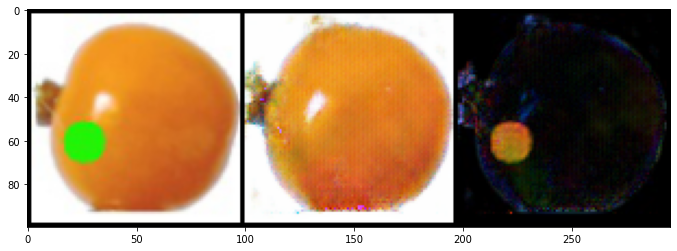

Anomary_score = 1454.286


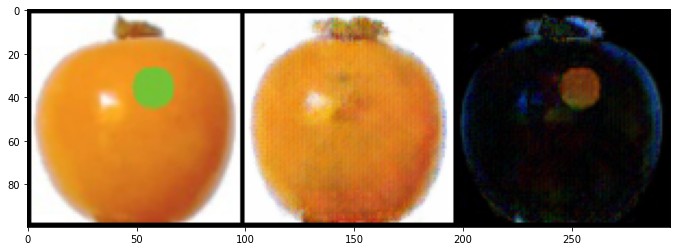

Anomary_score = 1597.874


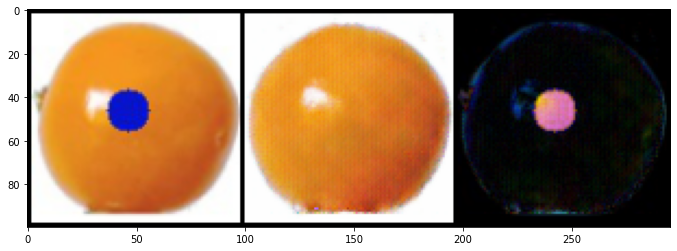

Anomary_score = 1334.105


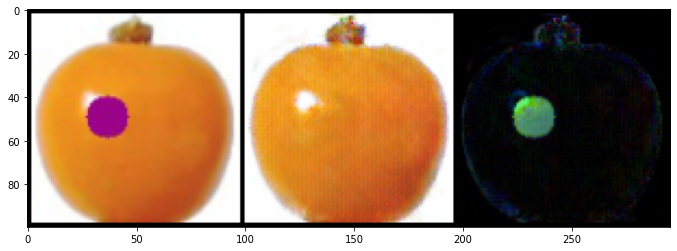

Anomary_score = 1819.682


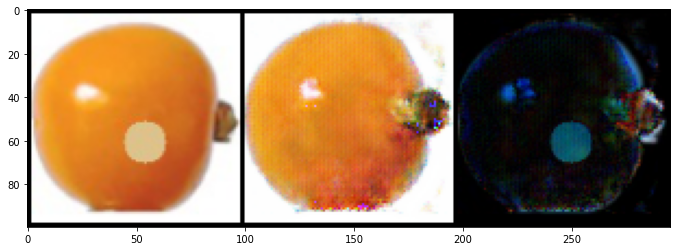

Anomary_score = 2232.562


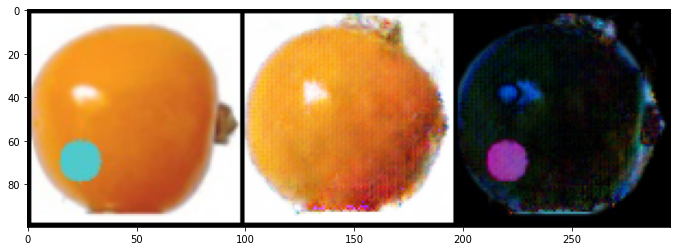

Anomary_score = 1547.693


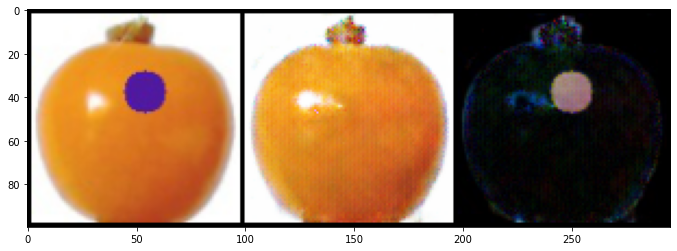

In [37]:
# 異常な画像で実行

test_root_anomaly = './data/fruits-360/Test/Physalis_damaged/'
test_dataset_anomaly = LoadFromFolder(test_root_anomaly, transform=transform_dict["test"])

test_images_anomaly = random.sample(list(test_dataset_anomaly), random_image_size)

# うまく再現されず、異常スコアが高くなっていれば成功
for idx in range(len(test_images_anomaly)):

    x = test_images_anomaly[idx].view(1, 3, IMAGE_SIZE, IMAGE_SIZE)
    x = Variable(x).to(device)
    
    z_o = optimize_z(x)
    G_z_o = model_G(z_o)
    loss = Anomaly_score(x, G_z_o)
    diff_img = torch.abs(x - G_z_o)

    print(f"Anomary_score = {loss.cpu().data:.3f}")
    comparison = torch.cat([x.to("cpu"), G_z_o.to("cpu"), diff_img.to("cpu")])
    joined_image = make_grid(comparison, nrow=3).detach().numpy()
    joined_image = np.transpose(joined_image, [1, 2, 0])
    
    plt.figure(figsize=(12, 4))
    plt.imshow((joined_image * 255).astype(np.uint8))
    plt.show()
